In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [11]:
def remove_high_corr_features(df, threshold=0.95):
    """Remove features with correlation > threshold using upper triangle"""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=drop_cols), drop_cols


In [13]:
def remove_outliers_iqr(df, features=None, multiplier=1.5):
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns

    Q1 = df[features].quantile(0.25)
    Q3 = df[features].quantile(0.75)
    IQR = Q3 - Q1

    is_outlier = ((df[features] < (Q1 - multiplier * IQR)) | 
                  (df[features] > (Q3 + multiplier * IQR))).any(axis=1)

    filtered_df = df[is_outlier == False].copy()
    num_removed = is_outlier.sum()

    return filtered_df, num_removed


In [14]:
from sklearn.preprocessing import PowerTransformer

def apply_yeojohnson_transform(X):
    pt = PowerTransformer(method='yeo-johnson')
    X_transformed = pd.DataFrame(pt.fit_transform(X), columns=X.columns, index=X.index)
    return X_transformed, pt


In [15]:
def main():
    # Reproducibility
    np.random.seed(42)
    
    # Load and clean data
    df = pd.read_csv("../data/curated-solubility-dataset.csv")
    
    # Handle MolLogP outliers
    df = df[(df["Solubility"] <= 1) & (df["Solubility"] >= -9)]
    
    # Drop non-feature columns
    non_features = ["ID","Name","InChI","InChIKey","SMILES","SD","Ocurrences","Group"]
    df = df.drop(columns=non_features)
    
    # Safety check: Verify numeric features
    assert df.select_dtypes(exclude=np.number).empty, "Non-numeric features present" 
    
    # Split data
    y = df["Solubility"]
    X = df.drop(columns=["Solubility"])
    
    # Remove correlated features
    X, removed = remove_high_corr_features(X, 0.95)
    print(f"Removed high-corr features: {removed}")  #! Transparency

    X_outliers_removed, num_outliers = remove_outliers_iqr(X)
    y = y.loc[X_outliers_removed.index] # keep y aligend
    X = X_outliers_removed
    print(f"Removed {num_outliers} outlier rows based on IQR.")
    
    # Apply Yeo-Johnson normalization
    X, pt = apply_yeojohnson_transform(X)
    print("Applied Yeo-Johnson normalization to features.")

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Optimized XGBoost configuration
    model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=2000, 
        learning_rate=0.02, 
        max_depth=6,      
        subsample=0.8,       
        colsample_bytree=0.7,
        reg_alpha=0.1,       #! L1 
        reg_lambda=1.0,      #! L2 
        early_stopping_rounds=20,  
        random_state=42
    )
    
    # Training with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=50
    )
    
    # Evaluation
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    print(f"\nValidation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")
    
    #plots
    plt.figure(figsize=(10,6))
    plot_importance(model, max_num_features=15)
    plt.title("XGBoost Feature Importance")
    plt.show()

Removed high-corr features: ['HeavyAtomCount', 'NumValenceElectrons', 'LabuteASA']
Removed 3618 outlier rows based on IQR.
Applied Yeo-Johnson normalization to features.
[0]	validation_0-rmse:2.01507
[50]	validation_0-rmse:1.20425
[100]	validation_0-rmse:1.01668
[150]	validation_0-rmse:0.96881
[200]	validation_0-rmse:0.95202
[250]	validation_0-rmse:0.94227
[300]	validation_0-rmse:0.93536
[350]	validation_0-rmse:0.93046
[400]	validation_0-rmse:0.92501
[450]	validation_0-rmse:0.92098
[500]	validation_0-rmse:0.91857
[550]	validation_0-rmse:0.91585
[600]	validation_0-rmse:0.91308
[650]	validation_0-rmse:0.91175
[700]	validation_0-rmse:0.90957
[750]	validation_0-rmse:0.90838
[800]	validation_0-rmse:0.90720
[850]	validation_0-rmse:0.90578
[878]	validation_0-rmse:0.90572

Validation RMSE: 0.9056
Validation R²: 0.8034


<Figure size 1000x600 with 0 Axes>

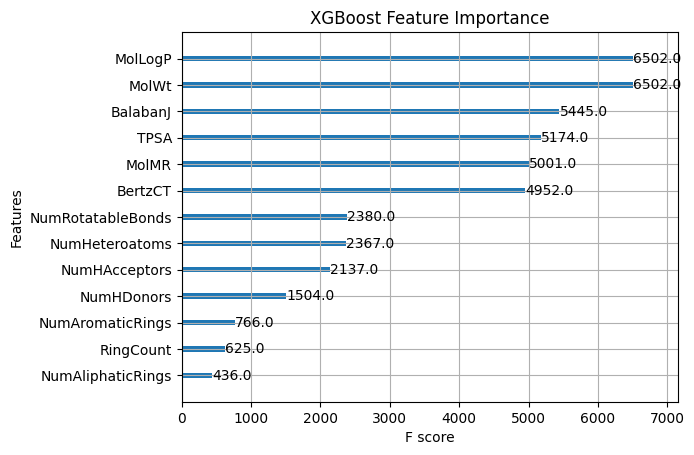

In [16]:
if __name__ == "__main__":
    main()